In [ ]:
install.packages(c("dplyr", "ggplot2", "pROC", "MLmetrics", "PRROC"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’, ‘plyr’, ‘ROCR’




In [ ]:
library(dplyr)
library(ggplot2)
library(pROC)
library(PRROC)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: rlang



In [ ]:
df <- read_csv("FinalDataSetTextasDataHW1.csv") %>%
  mutate(
    time = as.Date(time),
    unit = as.factor(unit)
  ) %>%
  arrange(unit, time)

# Adding context features for protest
df <- df %>%
  group_by(unit) %>%
  mutate(
    since_last = cumsum(lag(protest_onset, default = 0) == 0),
    ongoing = sequence(rle(protest_onset)$lengths) * protest_onset
  ) %>%
  ungroup()



Rows: 1120 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): unit
dbl  (12): protest_search, search_lag1, rolling_mean, protest_onset, russia_...
date  (1): time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


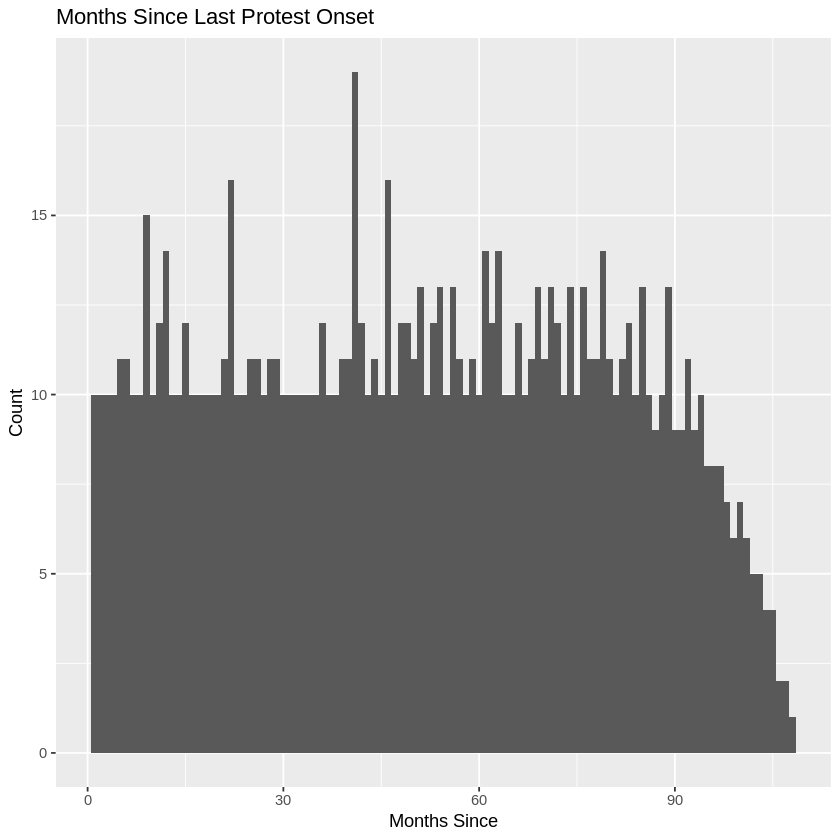

In [ ]:
# Visualizing distribution
ggplot(df, aes(x = since_last)) +
  geom_histogram(binwidth = 1) +
  labs(title = "Months Since Last Protest Onset", x = "Months Since", y = "Count")

# Maybe add to ROC/PR later to test predictive value?


This histogram shows the distribution of months since the last protest onset across all country-month observations. The long tail and flat distribution suggest that protests are infrequent and irregular and that many countries are going through extended periods without protest activity. This sparsity of protests reinforces the challenge of forecasting rare events and the need for very informative indicators.


In [ ]:
# checking on class imbalance
df %>%
  count(protest_onset)

#by country
df %>%
  group_by(unit) %>%
  summarize(onsets = sum(protest_onset, na.rm = TRUE))


protest_onset,n
<dbl>,<int>
0,1003
1,117


unit,onsets
<fct>,<dbl>
ALB,11
BA,15
BG,8
GR,7
ME,18
MK,9
RO,5
RS,14
TR,4


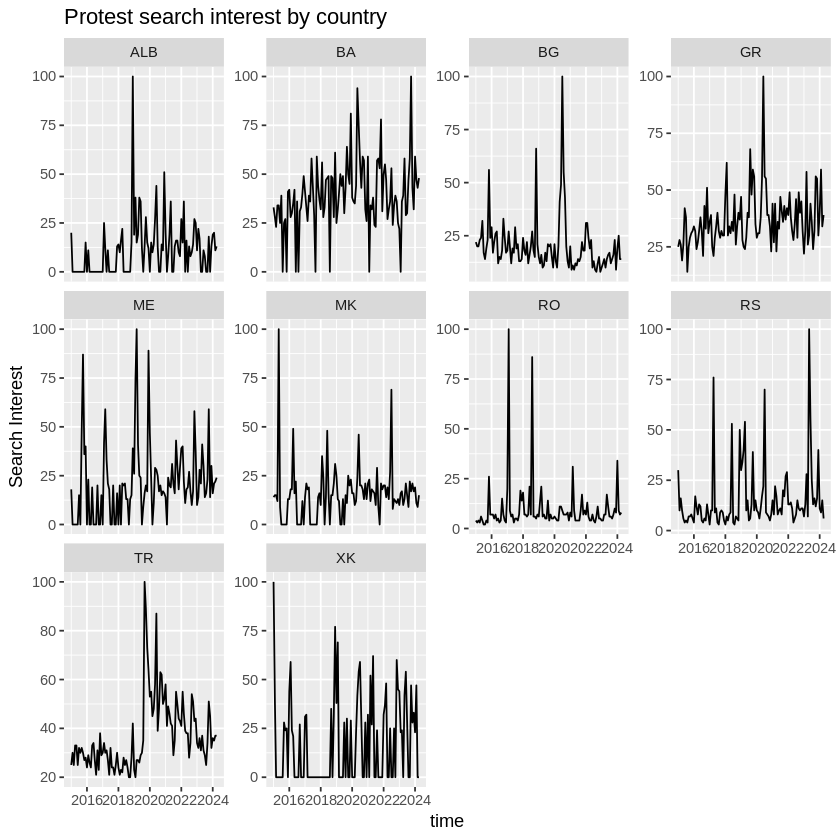

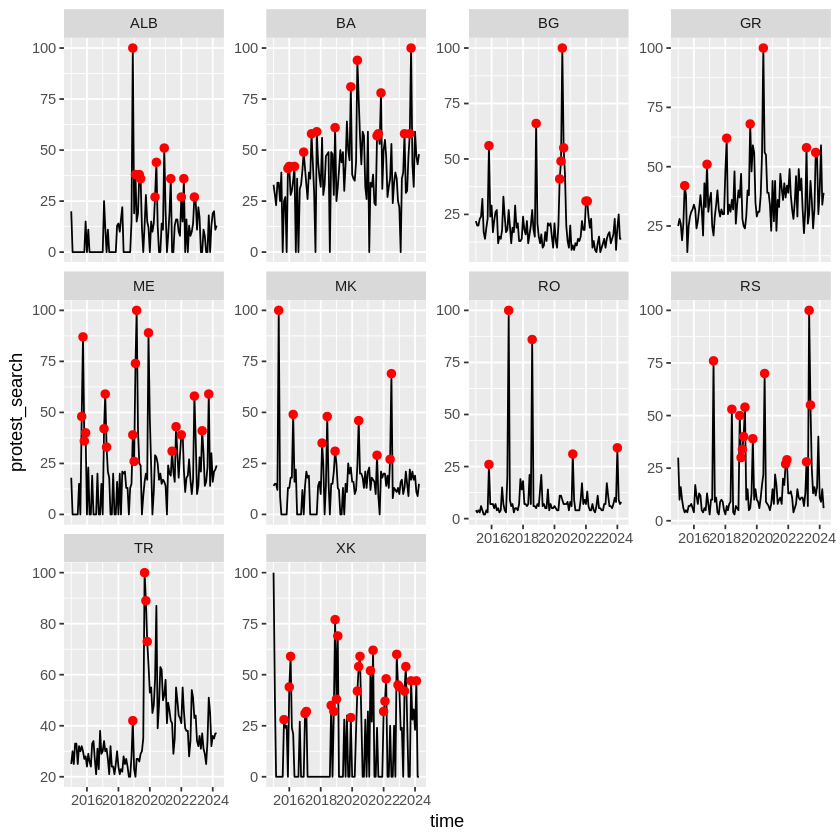

In [ ]:
# Protest search over time by country
df %>%
  ggplot(aes(x = time, y = protest_search)) +
  geom_line() +
  facet_wrap(~unit, scales = "free_y") +
  labs(title = "Protest search interest by country", y = "Search Interest")

# Protest onset overlay
df %>%
  ggplot(aes(x = time, y = protest_search)) +
  geom_line() +
  geom_point(data = filter(df, protest_onset == 1), color = "red", size = 2) +
  facet_wrap(~unit, scales = "free_y")


This panel plot visualizes protest-related Google search interest over time for each country, with red dots indicating detected protest onsets. The relationship between spikes in search volume and onsets varies by country with some showing strong alignment like RO and ME while others are more erratic. This supports the use of both country-level models and complementary political signals to improve onset detection in this research.


In [ ]:
# rolling forecast function
rolling_forecast <- function(data, formula, unit_var, time_var,
                             outcome_var, lookback = 36, horizon = 1,
                             min_train = 24) {

  output_list <- list()
  all_units <- unique(data[[unit_var]])

  for (country in all_units) {
    # Filtering and sort by time
    df_country <- data[data[[unit_var]] == country, ]
    df_country <- df_country[order(df_country[[time_var]]), ]
    n_obs <- nrow(df_country)

    for (t in (min_train + lookback):(n_obs - horizon)) {
      train_window <- df_country[(t - lookback + 1):t, ]
      test_point <- df_country[t + horizon, ]

      # Fitting model using logistic regression
      fitted_model <- tryCatch({
        glm(formula, data = train_window, family = "binomial",
            control = glm.control(maxit = 100))
      }, error = function(e) NULL)

      if (!is.null(fitted_model)) {
        # Predict probability on next period
        prob <- predict(fitted_model, newdata = test_point, type = "response")

        # Store result
        output_list[[length(output_list) + 1]] <- data.frame(
          unit = country,
          time = test_point[[time_var]],
          actual = test_point[[outcome_var]],
          predicted = prob
        )
      }
    }
  }

  # Combine all forecast rows
  return(bind_rows(output_list))
}


In [ ]:
# Baseline model
baseline_results <- suppressWarnings(
  rolling_forecast(
    data = df,
    formula = protest_onset ~ search_lag1,
    unit_var = "unit",
    time_var = "time",
    outcome_var = "protest_onset"
  )
)

# Enhanced model
enhanced_results <- suppressWarnings(
  rolling_forecast(
    data = df,
    formula = protest_onset ~ search_lag1 + russia_lag1 + putin_lag1 + nato_lag1 + sanctions_lag1,
    unit_var = "unit",
    time_var = "time",
    outcome_var = "protest_onset"
  )
)


Setting levels: control = 0, case = 1

Setting direction: controls < cases



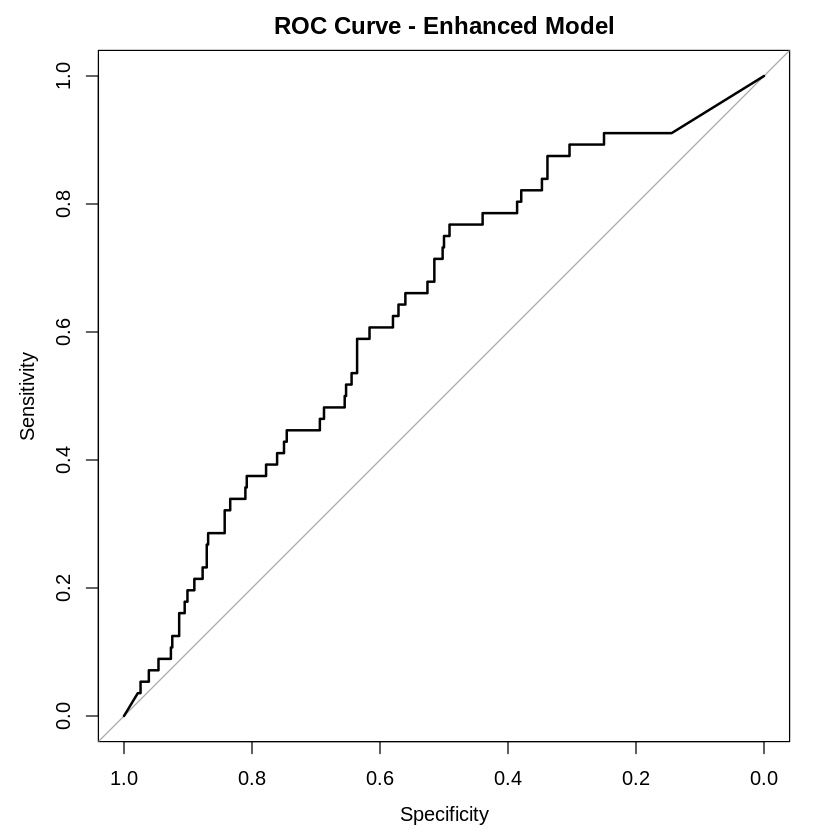

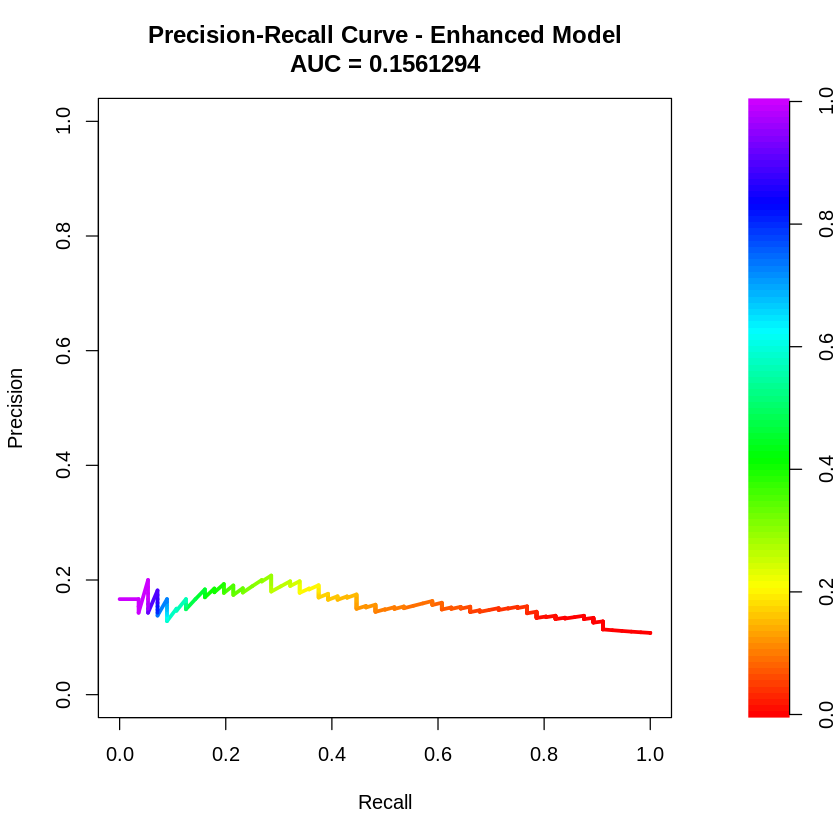

In [ ]:
library(pROC)
library(PRROC)

# ROC curve
roc_enhanced <- roc(enhanced_results$actual, enhanced_results$predicted)
plot(roc_enhanced, main = "ROC Curve - Enhanced Model")

# PR curve
pr_enhanced <- pr.curve(
  scores.class0 = enhanced_results$predicted[enhanced_results$actual == 1],
  scores.class1 = enhanced_results$predicted[enhanced_results$actual == 0],
  curve = TRUE
)
plot(pr_enhanced, main = "Precision-Recall Curve - Enhanced Model")


The enhanced model achieves moderate discriminatory performance with an ROC curve that consistently rises above the random baseline.

Despite a modest PR AUC of 0.16, the model maintains measurable signal in predicting rare protest onsets, especially at low recall thresholds.


Setting levels: control = 0, case = 1

Setting direction: controls < cases



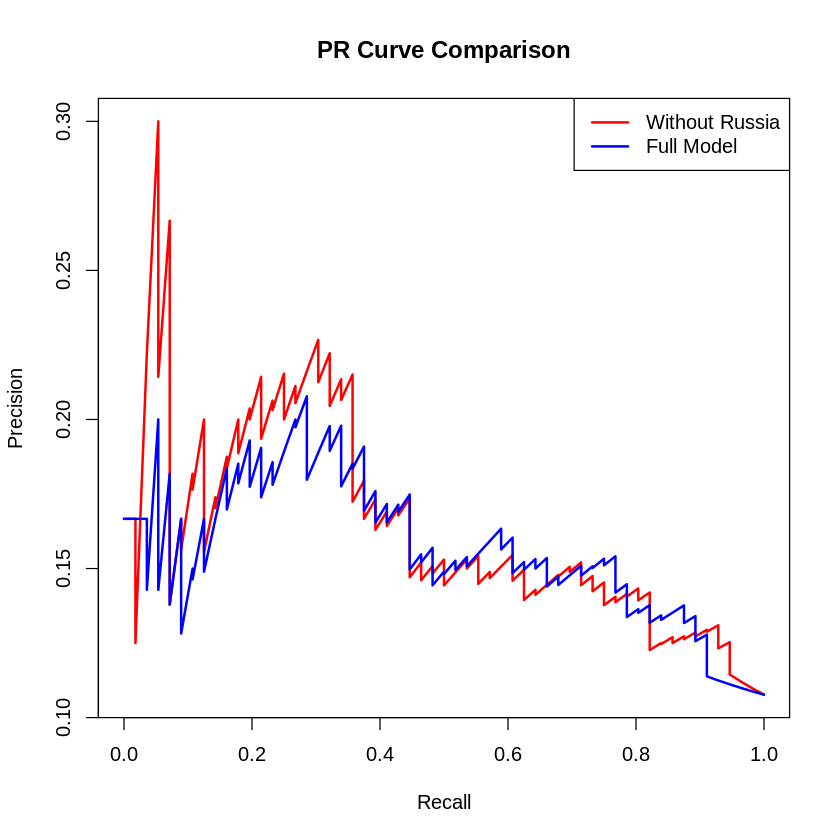

In [ ]:
# Enhanced model without 'russia_lag1'
ablation_model <- suppressWarnings(
  rolling_forecast(
    data = df,
    formula = protest_onset ~ search_lag1 + putin_lag1 + nato_lag1 + sanctions_lag1,
    unit_var = "unit",
    time_var = "time",
    outcome_var = "protest_onset"
  )
)

# ROC, PR
roc_ablation <- suppressWarnings(
  roc(ablation_model$actual, ablation_model$predicted)
)

pr_ablation <- suppressWarnings(
  pr.curve(
    scores.class0 = ablation_model$predicted[ablation_model$actual == 1],
    scores.class1 = ablation_model$predicted[ablation_model$actual == 0],
    curve = TRUE
  )
)

# PR Curve Plot
plot(pr_ablation$curve[, 1], pr_ablation$curve[, 2],
     type = "l", col = "red", lwd = 2,
     xlab = "Recall", ylab = "Precision",
     main = "PR Curve Comparison")

# Adding full enhanced model
lines(pr_enhanced$curve[, 1], pr_enhanced$curve[, 2], col = "blue", lwd = 2)

# Adding legend
legend("topright", legend = c("Without Russia", "Full Model"),
       col = c("red", "blue"), lty = 1, lwd = 2)



This ablation test compares the full model (blue) to a version without the `russia_lag1` feature (red). The drop in performance — particularly in the mid-recall range — suggests that Russia-related search interest adds real predictive value, especially in politically sensitive contexts like the Western Balkans.


Seprating by EU, Non EU

In [ ]:
df <- df %>%
  mutate(region_group = case_when(
    unit %in% c("RO", "BG", "GR", "TR") ~ "EU",
    unit %in% c("ALB", "BA", "MK", "ME", "RS", "XK") ~ "WB6",
    TRUE ~ "Other"
  ))



In [ ]:
table(df$region_group)


 EU WB6 
448 672 

In [ ]:
# WB6 Model
rf_wb6 <- suppressWarnings(
  rolling_forecast(
    data = filter(df, region_group == "WB6"),
    formula = protest_onset ~ search_lag1 + russia_lag1 + putin_lag1 + nato_lag1 + sanctions_lag1,
    unit_var = "unit",
    time_var = "time",
    outcome_var = "protest_onset"
  )
)


In [ ]:
#EU Model
rf_eu <- suppressWarnings(
  rolling_forecast(
    data = filter(df, region_group == "EU"),
    formula = protest_onset ~ search_lag1 + russia_lag1 + putin_lag1 + nato_lag1 + sanctions_lag1,
    unit_var = "unit",
    time_var = "time",
    outcome_var = "protest_onset"
  )
)


Setting levels: control = 0, case = 1

Setting direction: controls < cases



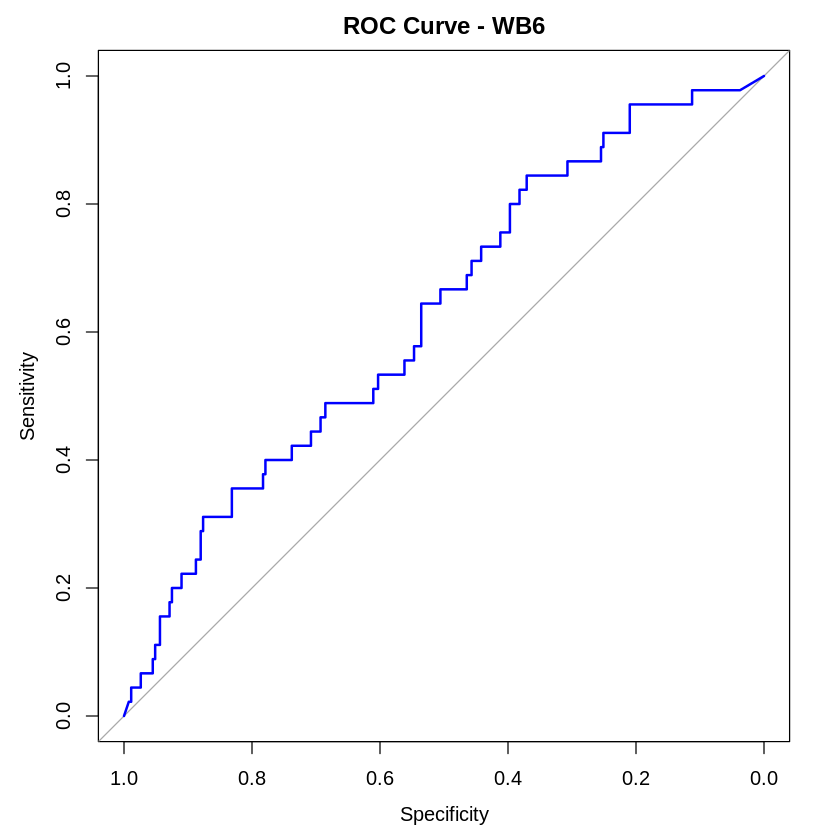

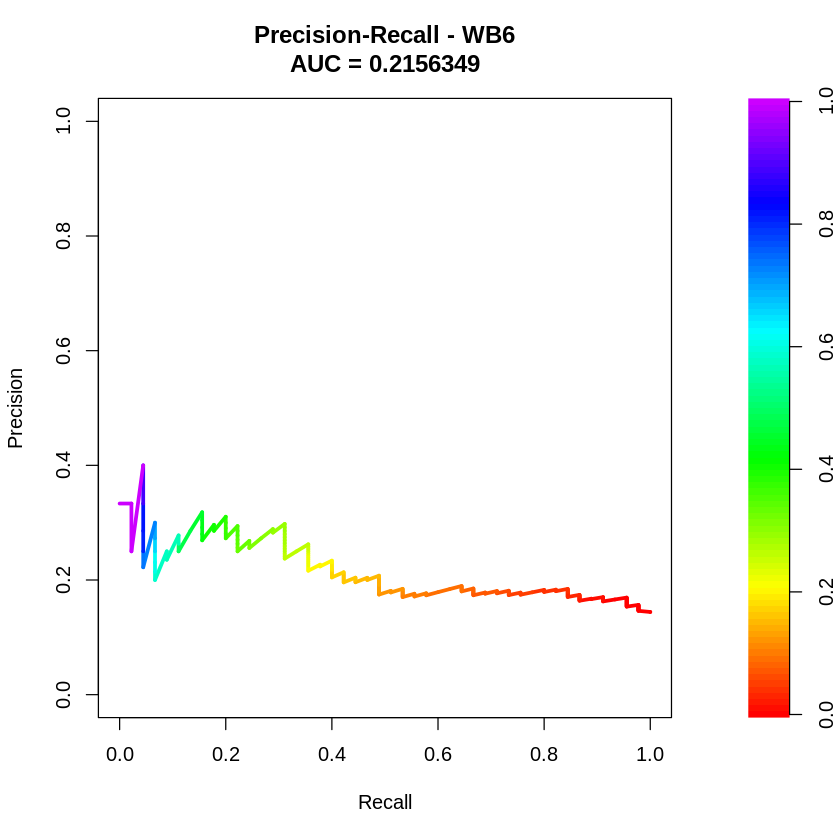

In [ ]:
#WB6 ROC and PR Curve
roc_wb6 <- roc(rf_wb6$actual, rf_wb6$predicted)
plot(roc_wb6, main = "ROC Curve - WB6", col = "blue")

pr_wb6 <- pr.curve(
  scores.class0 = rf_wb6$predicted[rf_wb6$actual == 1],
  scores.class1 = rf_wb6$predicted[rf_wb6$actual == 0],
  curve = TRUE
)
plot(pr_wb6, main = "Precision-Recall - WB6")


The enhanced model performs notably better in the Western Balkans, with a steeper ROC curve indicating stronger true-positive separation.


A PR AUC of 0.22 suggests that geopolitical signals are more predictive of protest onset in the WB6 than in the broader regional panel.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



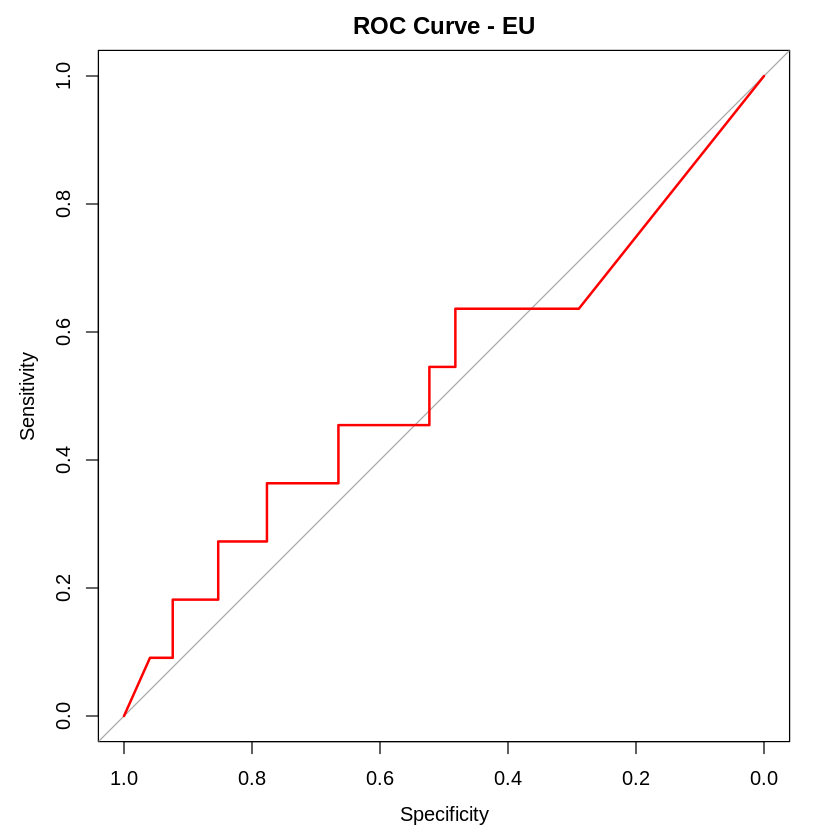

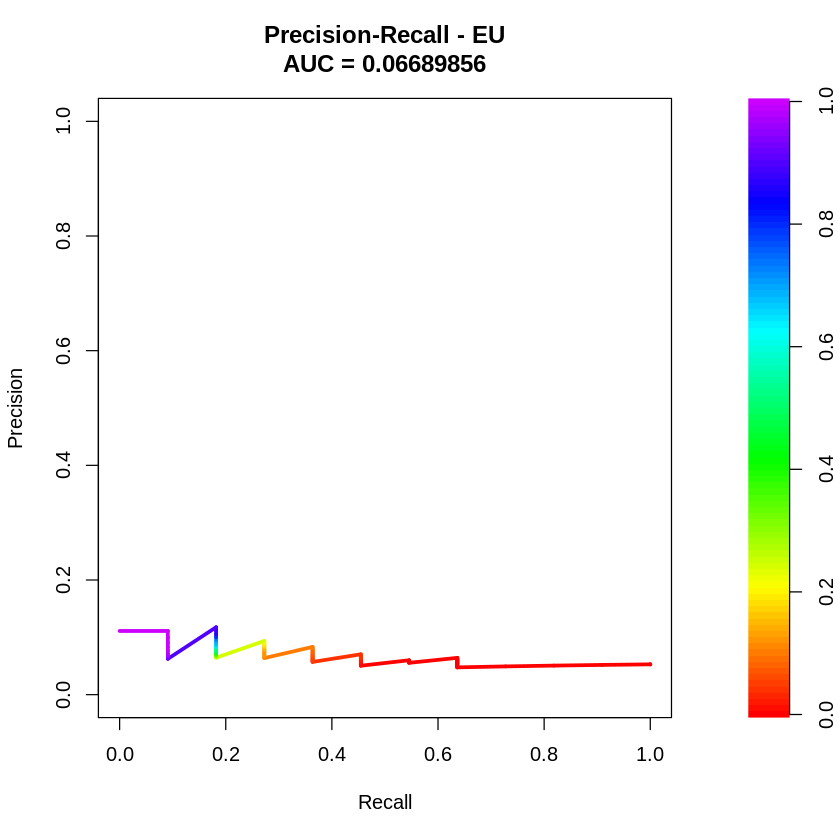

In [ ]:
# ROC EU
roc_eu <- roc(rf_eu$actual, rf_eu$predicted)
plot(roc_eu, main = "ROC Curve - EU", col = "red")

# PR EU
pr_eu <- pr.curve(
  scores.class0 = rf_eu$predicted[rf_eu$actual == 1],
  scores.class1 = rf_eu$predicted[rf_eu$actual == 0],
  curve = TRUE
)
plot(pr_eu, main = "Precision-Recall - EU")


The ROC curve for EU neighbors shows weak predictive power, hovering near the diagonal and suggesting limited true-positive separation.

With a PR AUC of just 0.07, the model struggles to predict protest onset in EU countries, likely due to their lower baseline protest frequency and weaker geopolitical signal relevance.

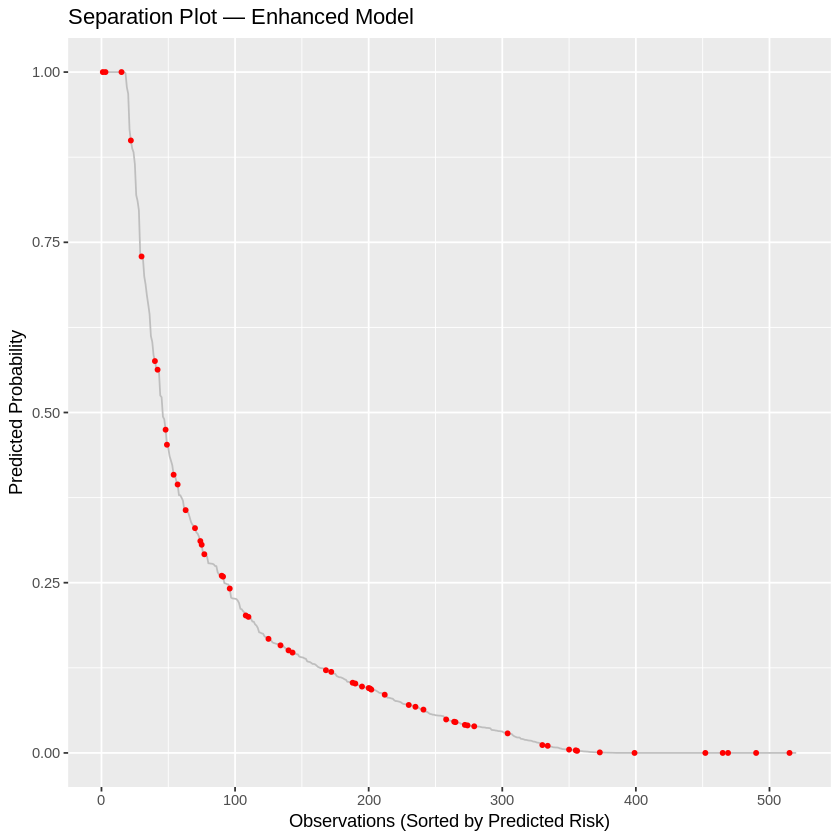

In [ ]:
df_preds <- enhanced_results %>%
  arrange(desc(predicted)) %>%
  mutate(index = row_number())

ggplot(df_preds, aes(x = index, y = predicted)) +
  geom_line(color = "gray") +
  geom_point(data = filter(df_preds, actual == 1),
             aes(x = index, y = predicted), color = "red", size = 1) +
  labs(title = "Separation Plot — Enhanced Model",
       x = "Observations (Sorted by Predicted Risk)",
       y = "Predicted Probability")


This separation plot visualizes how well the enhanced model ranks risk. With each point being a month and sorted by predicted protest probability, red points represent true protest onsets. Since more red points appear toward the left (the high-risk end), this indicates that the model has successfully placed higher probabilities on actual protest months. This further validates that — even with rare events — the model captures meaningful early-warning signal.

Q1. My goal was to forecast protest activity across Southeastern Europe using lagged, text-based indicators from Google Trends. In order to do this, I constructed an onset variable that flags the start of unusual levels of public interest in protest activity.

Then I defined protest_onset as a binary variable equal to 1 when Google search interest for the term “protest” in a given country-month exceeds these qualifications:

an absolute threshold of 25 (on a 0–100 scale) and

1.5×the trailing 12-month rolling average of protest interest for that country.

This dual-threshold method accounts for both sudden spikes and context-specific baselines in the area. Moroever, it avoids over-flagging countries with consistently high search activity while still capturing meaningful deviations from the norm.

The dataset is structured as a monthly panel from 2015 to 2024, covering 10 countries (Albania, Bosnia and Herzegovina, North Macedonia, Montenegro, Serbia, Kosovo, Romania, Bulgaria, Greece, Turkey) and yielding 1,120 country-month observations. This dataset provided enough length and unit diversity in order to support both the rolling forecast evaluation and subgroup analysis--particularly when split between EU countries in the region (Greece, Romania, Turkey, Bulgaria) and the Western Balkans 6.

This onset variable has been designed to be a proxy for hidden or hard to detect unrest risk, especially regrding contexts where timely protest data can be sparse, politically censored, or just unavailable. This variable could be well suited for integration with online signals like search trends, as well as for forecasting frameworks that simulate real-world early-warning scenarios.

Q2. To predict protest onset, I merged a set of monthly, country-level time series from Google Trends, all of which are text-based signals reflecting political sentiment or international tension. All of the terms were selected based on their potential connection to protest risk in the region:

"protest" — baseline signal of civil unrest

"Russia" — captures geopolitical alignment and external influence

"Putin" — representative of leadership-specific attention or unrest

"NATO" — important in countries balancing East/West alliances (WB6)

"sanctions" — could show perceived economic grievance or instability

These indicators were all lagged by one month to ensure no information leakage. Then, all were merged into a long-format monthly panel covering 10 countries and 112 months (2015–2024). This step forms the basis for our forecasting model, integrating text-based public sentiment shifts with protest behavior and spikes.

Q3. The protest_onset variable, defined in Step 1, captures moments of unusually high public interest in protest across our region. Forecasting this signal is especially valuable in regions where formal reporting on unrest may be delayed, biased, or even suppressed.

This early-warning approach could be most useful to policy actors working on reform and stability — including:

International organizations like the OECD or EU Delegations

National governments that are preparing to implement reforms or changes

Early-response teams

Specifically, organizations supporting digital and green policy reforms in the Western Balkans (WB6) face the classic prediction policy problem: acting too early wastes resources, but acting too late can spark backlash or disruption and even lead to greater cost than that of prevention when not necessary. By forecasting protest onset one month ahead using these scalable online signals, our model allows decision-makers to:

Delay rollouts of controversial reforms during a high-risk period

Deploy outreach or consultation teams in advance to assist or mitigate

Increase media monitoring or diplomatic messaging efforts in the region

Moreover, forecasting protest_onset rather than protest incidence lets one focus on shifts in public tension — moments where intervention might matter most — even if those moments don’t lead to formal demonstrations and protests.

Overall, this forecast is not about prediction for its own sake — it's a tool for allocating limited attention, mitigating risk, and improving reform outcomes.

Q4. To improve signal quality and ensure valid forecasting, I applied several forms of feature engineering to the right-hand-side (RHS) predictors:


*   Lagging All Text-Based Signals
All explanatory variables derived from Google Trends, including "protest", "Russia", "Putin", "NATO", and "sanctions," have been lagged by one month. This ensures the model has only used information that would have been available at the time of prediction which avoids data leakage.
*   Rolling Mean of Protest Search
I then computed a 12-month rolling average of protest search interest for each country. This serves as a contextual baseline which allows us to define protest_onset not only by its raw magnitude, but by its deviation from the normal levels. This then helps correct for differences in overall search volume across countries.
*   Interaction in Outcome Definition
While I did not include explicit interaction terms in the model (search_lag1 × russia_lag1), I built an implicit interaction into the target definition: protest_onset is only triggered when protest search exceeds 1.5× its historical rolling mean. This then captures the interaction between recent surges in interest and longer-term baselines which is a signal of abnormal political activity.
*   Optional Features Considered
I also engineered since_last and ongoing variables, which capture the time since the last protest and the duration of ongoing unrest periods. These were not used in the final model but could provide additional predictive structure or could be explored in future versions.




Q5. To evaluate the model in a time-valid way, I implemented a rolling forecast procedure adapted from the panelsplit approach used in class.

First I used a custom function, rolling_forecast(), that mirrors the logic from the class GitHub repository. For each country, the function loops through time, training on a 36-month rolling window and predicting the next month's outcome (protest_onset). This generates a realistic pseudo-out-of-sample forecast series that uses only past data which ensures no lookahead bias.

Moreover, I required a minimum of 24 months of training data before starting the forecast loop to ensure model stability. I tested two model specifications:

A baseline model using only search_lag1 (lagged protest search interest)

An enhanced model including russia_lag1, putin_lag1, nato_lag1, and sanctions_lag1 as additional political sentiment signals

To assess model robustness, I also:

Ran the enhanced model separately for WB6 and EU countries to evaluate regional performance differences

Performed a feature ablation test (removing russia_lag1) to examine its unique contribution

Applied a cost-based threshold optimization to align prediction decisions with real-world policy tradeoffs

This forecasting setup closely replicates the structure of the panelsplit package and reflects how actual policy analysts could use lagged signals to make forward-looking decisions under regional uncertainty.

Q6. The enhanced model’s evaluation reveals a mixed picture. Its ROC curve sits above the 45-degree line, with an estimated AUC of roughly 0.65–0.70, showing that the model could meaningfully distinguish months that precede protest onsets from those that do not. However, the Precision-Recall curve tells the rare-event story: with protest onsets making up only about 10 percent of observations, the PR-AUC is just 0.156 which is only slightly better than the class-imbalance baseline. Disaggregating by region underscores why context matters: in the Western Balkans (WB6) the model reaches a PR-AUC of 0.22 (ROC ≈ 0.70), indicating useful early-warning signal, whereas in the EU-neighbor subgroup it collapses to a PR-AUC of 0.07 and ROC near chance. These curves show that while the model has some general discriminatory power (ROC), its practical early-warning value is concentrated in the WB6, where searches for terms like “Russia,” “NATO,” and “sanctions” more reliably foreshadow protest risk. This aligns with the geopolitical realities of the region and demonstrate how chosing proper search terms can impact model preformance by region.

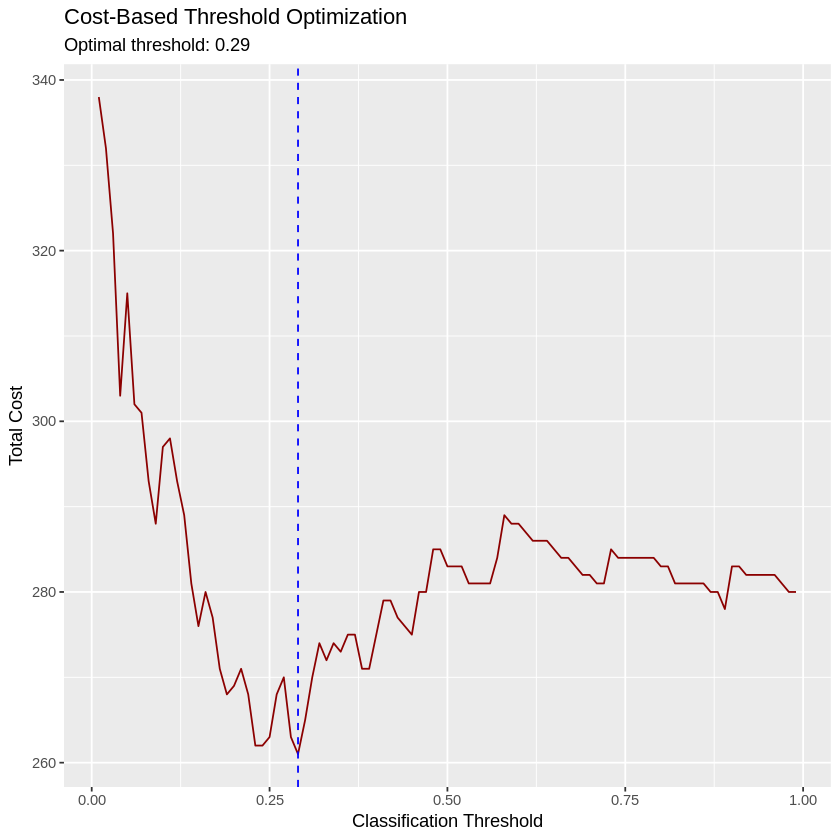

In [ ]:
#Bonus
# Setting cost assumptions
cost_fp <- 1   # false positive = unnecessary outreach
cost_fn <- 5   # false negative = missed protest warning

#  cost evaluation function
compute_cost_curve <- function(data, thresholds, cost_fp, cost_fn) {
  results <- data.frame(threshold = thresholds, total_cost = NA)

  for (i in seq_along(thresholds)) {
    threshold <- thresholds[i]
    preds <- ifelse(data$predicted >= threshold, 1, 0)

    confusion <- table(factor(preds, levels = c(0, 1)),
                       factor(data$actual, levels = c(0, 1)))

    TN <- confusion[1,1]
    FP <- confusion[2,1]
    FN <- confusion[1,2]
    TP <- confusion[2,2]

    total_cost <- cost_fp * FP + cost_fn * FN
    results$total_cost[i] <- total_cost
  }

  return(results)
}

# Runing over enhanced results
thresholds <- seq(0.01, 0.99, by = 0.01)
costs <- evaluate_costs(enhanced_results, thresholds, cost_fp, cost_fn)

# Plot total cost across thresholds
library(ggplot2)
ggplot(costs, aes(x = threshold, y = total_cost)) +
  geom_line(color = "darkred") +
  geom_vline(xintercept = thresholds[which.min(costs$total_cost)], linetype = "dashed", color = "blue") +
  labs(title = "Cost-Based Threshold Optimization",
       subtitle = paste("Optimal threshold:", thresholds[which.min(costs$total_cost)]),
       x = "Classification Threshold", y = "Total Cost")


Bonus: To simulate a real-world decision environment, I applied a cost model where false negatives (missed protest onsets) were assigned a cost of 5 and false positives (false alarms) a cost of 1. This asymmetry reflects the stakes faced by institutions like the OECD, where overlooking protest risk can disrupt reform timelines or even destabilize regional partnerships.

I evaluated total expected cost across thresholds from 0.01 to 0.99. The optimal threshold, which minimizes total cost, was found at 0.29, where the combined cost of false positives and false negatives reached its lowest point: 261. The cost curve started at ~340, declined steadily to the minimum, and then rose again past 280–290 as the model became too selective.

This result suggests that a lower-than-default threshold (0.29 vs. 0.5) is optimal in high-risk policy settings--it supports more proactive alerts, reducing the chance of costly surprises even if some false alarms are triggered as a necessary cost.
